In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('dark'))
plt.rcParams['figure.figsize'] = (12 , 10)

In [9]:
!nvidia-smi

Thu Dec 25 12:06:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
import google
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

print(is_colab())


True


In [11]:
dfile = './data/names.txt' if not is_colab() else './sample_data/names.txt'
words = []
with open(dfile) as f:
    words = f.read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

## made dataset


In [12]:
#index the characters:
vocab = sorted(list(set(''.join(words))))
sti = {vocab[i] : i + 1 for i in range(len(vocab))}
sti['.'] = 0
its = {v : k for k , v in sti.items()}

In [13]:
# get x and y:
def build_dataset(words , n):
    x = []
    y = []
    ngram = n
    for word in words:
        context = [0] * ngram
        for ch in word:
            token = sti[ch]
            x.append(context)
            y.append(token)
            context = context[1:] + [token]

    x = torch.tensor(x)
    y = torch.tensor(y)
    print(f"{x.shape} , {y.shape}")
    return (x , y)

x , y = build_dataset(words , 3)

torch.Size([196113, 3]) , torch.Size([196113])


In [14]:
#split dataset into train , test and val:
import random
random.shuffle(words)
n = 3
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
xtrain , ytrain = build_dataset(words[:n1] , n)
xval , yval = build_dataset(words[n1:n2] , n)
xtest , ytest = build_dataset(words[n2:] , n)

torch.Size([157044, 3]) , torch.Size([157044])
torch.Size([19586, 3]) , torch.Size([19586])
torch.Size([19483, 3]) , torch.Size([19483])


## build and train model


In [7]:
# build model:
nvocab = 27
n = 3
ngram = n
nemb = 10
nhidden = 100
c = torch.randn((nvocab , nemb))
w1 = torch.randn((n * nemb , nhidden))
b1 = torch.randn(nhidden) * 0
w2 = torch.randn((nhidden , nvocab)) * 0.01
b2 = torch.rand(nvocab) * 0

parameters = [c , w1 , b1 , w2 , b2]
tparams = sum([param.nelement() for param in parameters])
for p in parameters:
    p.requires_grad = True

In [8]:
tparams

6097

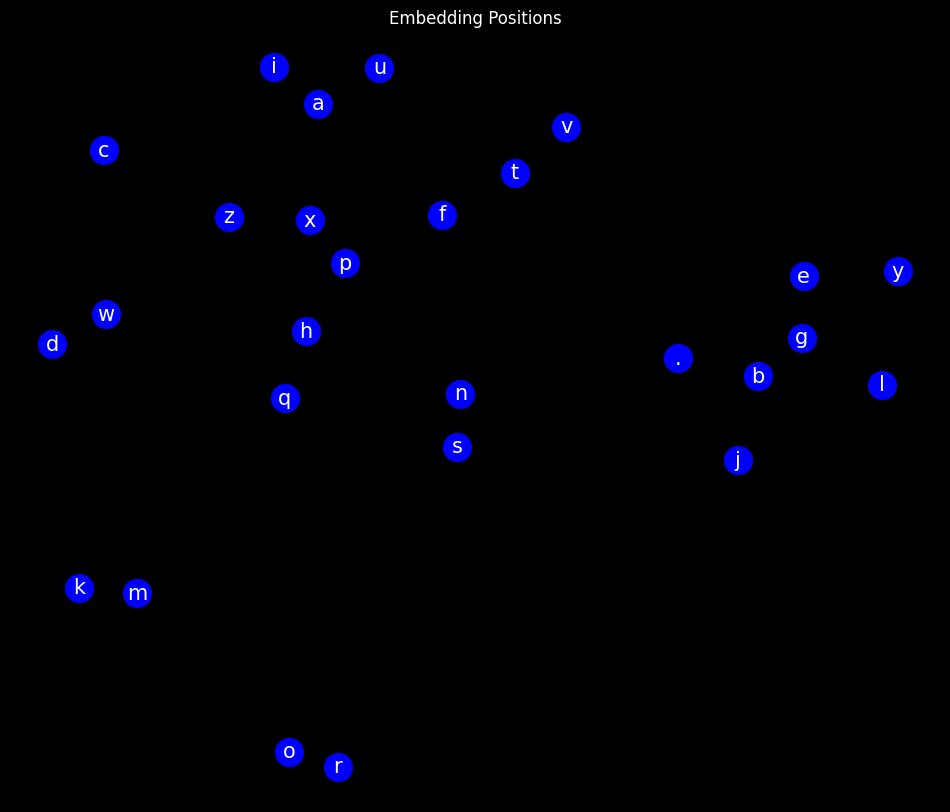

In [16]:
#plot embeddings:
from sklearn.manifold import TSNE
def plot_embeddings(embeddings):
    tsne = TSNE(n_components = 2 , perplexity = 3 , learning_rate = 100 , max_iter = 10000 , init = 'random' , random_state = 42)
    emb = tsne.fit_transform(embeddings.detach().numpy())
    # print(emb.shape)
    plt.scatter(emb[: , 0] , emb[: , 1] , color = 'blue' , s = 400)
    for i in range(emb.shape[0]):
        plt.text(emb[i , 0] , emb[i , 1] , its[i] , ha = 'center' , va = 'center' , fontsize = 15)
    plt.axis('off')
    plt.title('Embedding Positions')
plot_embeddings(c)

In [17]:
# training loop:
def train(xtrain , ytrain , iters = 100000):
    bsize = 64
    lossi = []
    stepi = []
    loss = None
    for i in range(iters):

        # print progress message every 10000 iter:
        if i % 10000 == 0:
            print(f'iteration:{i} , loss:{loss.log10().item() if loss != None else loss}')
        # get mini-batch
        ids = torch.randint(0 , xtrain.shape[0] , (bsize , ))
        x = xtrain[ids]
        y = ytrain[ids]
        # print(f"{x.shape=}")

        #convert to embeddings:
        embs = c[x].view((x.shape[0] , -1))
        # print(f"{embs.shape=}")

        #forward-pass:
        xx = torch.tanh(embs @ w1 + b1)
        logits = xx @ w2 + b2
        loss = torch.nn.functional.cross_entropy(logits , y)


        # backward-pass:
        # make gradients = None:
        for p in parameters:
            p.grad = None

        loss.backward()

        lr = 0.1 if i < 60000 else 0.01
        for p in parameters:
            p.data += -lr * p.grad

        # track-stats:
        lossi.append(loss.log10().item())

    #print final-loss:
    emb = c[xtrain].view((xtrain.shape[0] , -1))
    h = torch.tanh(emb @ w1 + b1)
    logits = h @ w2 + b2
    loss = torch.nn.functional.cross_entropy(logits , ytrain)
    print(f"final loss:{loss.item()}")

    return lossi

loss = train(xtrain , ytrain , 1000000)

iteration:0 , loss:None
iteration:10000 , loss:0.37296146154403687
iteration:20000 , loss:0.386589378118515
iteration:30000 , loss:0.3783997893333435
iteration:40000 , loss:0.35453638434410095
iteration:50000 , loss:0.369596391916275
iteration:60000 , loss:0.3290252089500427
iteration:70000 , loss:0.3227640688419342
iteration:80000 , loss:0.37708690762519836
iteration:90000 , loss:0.3620389401912689
iteration:100000 , loss:0.3727525472640991
iteration:110000 , loss:0.2747606933116913
iteration:120000 , loss:0.3490440845489502
iteration:130000 , loss:0.3693784773349762
iteration:140000 , loss:0.2774600684642792
iteration:150000 , loss:0.3718501031398773
iteration:160000 , loss:0.3940448462963104
iteration:170000 , loss:0.3510901927947998
iteration:180000 , loss:0.3321441113948822
iteration:190000 , loss:0.36459895968437195
iteration:200000 , loss:0.31697890162467957
iteration:210000 , loss:0.3219854533672333
iteration:220000 , loss:0.32414475083351135
iteration:230000 , loss:0.312159389

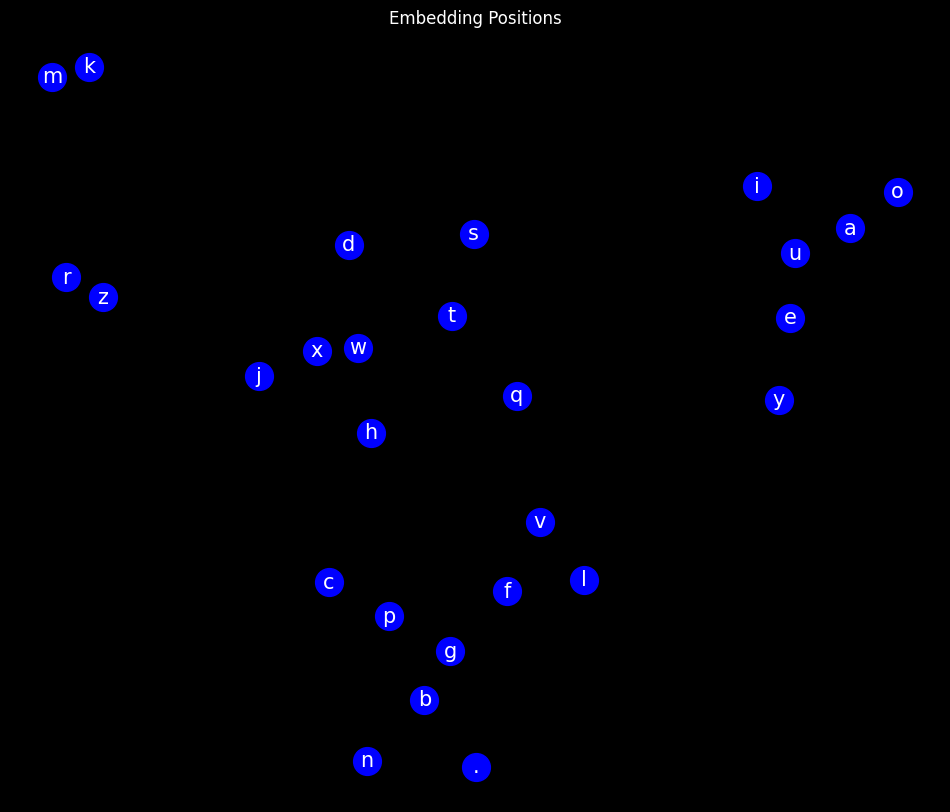

In [18]:
plot_embeddings(c)

## inference
